<a href="https://colab.research.google.com/github/Koanah/Fake-News-Detection/blob/main/Fake_News_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

FAKE NEWS DATASET ANALYSIS

In [ ]:
fake_news = pd.read_csv("/content/fake.csv")

In [ ]:
fake_news.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_news.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake_news['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

In [ ]:
# get the average number of words per text:
average_word_count = fake_news['text'].apply(lambda x: len(str(x).split())).mean()
print(f'Average number of words per text: {average_word_count:.2f}')

Average number of words per text: 423.20


In [ ]:
fake_news['subject'].value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


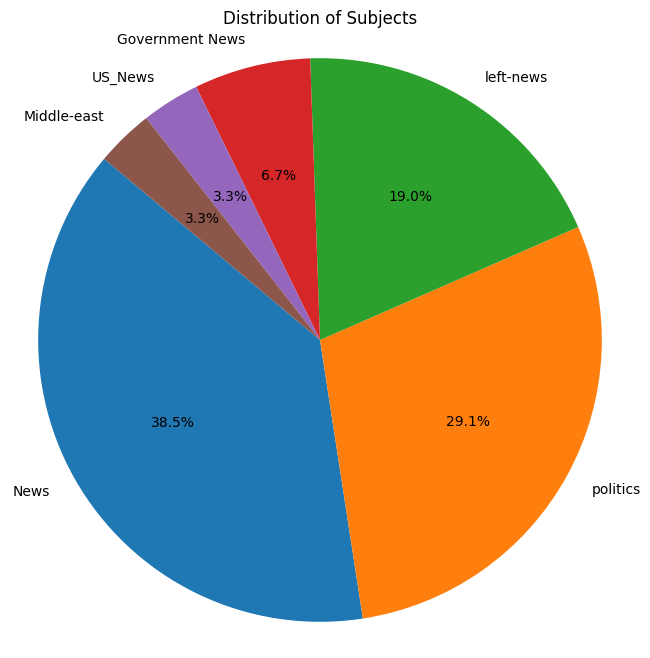

In [ ]:
# pie chart to visualize the distrubution of the subjects in the dataset
subject_counts = fake_news['subject'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Subjects')
plt.axis('equal')
plt.show()

<Axes: xlabel='subject', ylabel='count'>

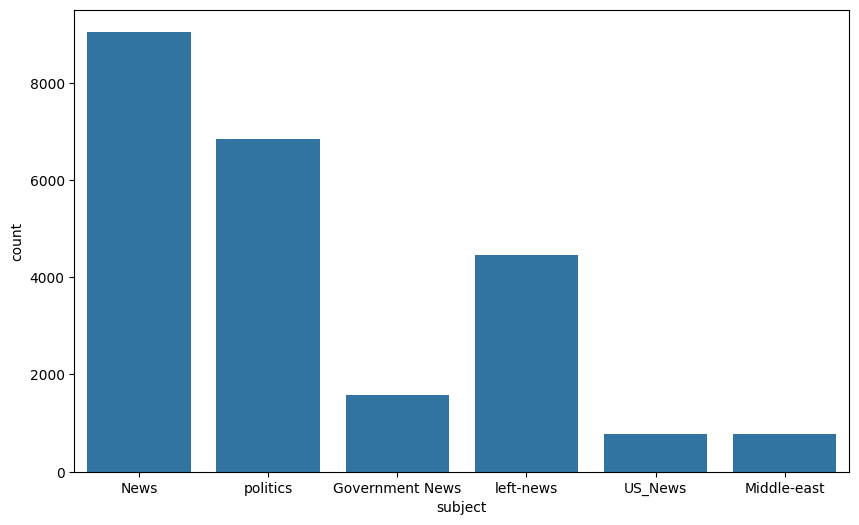

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data = fake_news)

In [ ]:
# term frequency bar plot  - use a horizontal or vertical bar plot of the top N most frequent word
from collections import Counter

<Axes: xlabel='count', ylabel='word'>

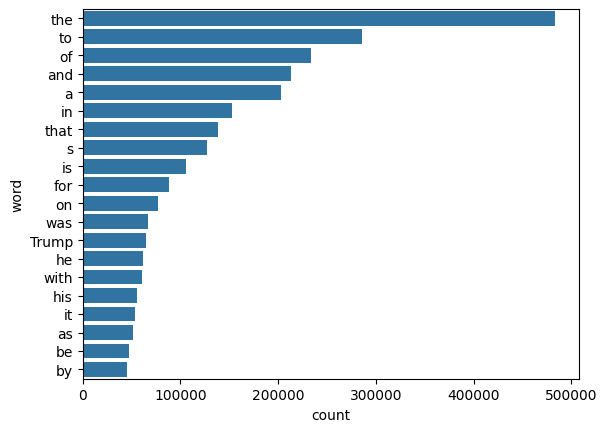

In [ ]:
words = ' '.join(fake_news['text']).split()
common_words = Counter(words).most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(data=words_df, y='word', x='count')

In [ ]:
# check for any empty rows in the fake news dataset:
def find_empty_rows(df, text_column='text'):
    # Find empty or whitespace-only or null rows
    empty_rows = df[df[text_column].str.strip().eq('') | df[text_column].isnull()]

    if not empty_rows.empty:
        print(f"Empty text rows found at indices: {list(empty_rows.index)}")
    else:
        print("No empty text rows found.")

    return empty_rows

In [ ]:
def remove_empty_rows(df, text_column='text'):
    # Find rows where the specified column is empty or contains only whitespace
    empty_rows = df[df[text_column].str.strip().eq('') | df[text_column].isnull()]

    if not empty_rows.empty:
        print(f"Dropping the following empty row indices: {list(empty_rows.index)}")
        df = df.drop(empty_rows.index, axis=0)
    else:
        print("No empty rows found.")

    return df

In [ ]:
find_empty_rows(fake_news, text_column='text')

Empty text rows found at indices: [10923, 11041, 11190, 11225, 11236, 11241, 11247, 11249, 11267, 11268, 11283, 11284, 11285, 11289, 11290, 11292, 11295, 11296, 11301, 11303, 11304, 11305, 11309, 11314, 11317, 11319, 11322, 11330, 11334, 11335, 11340, 11343, 11348, 11351, 11352, 11357, 11371, 11373, 11374, 11382, 11397, 11402, 11403, 11409, 11410, 11412, 11415, 11419, 11421, 11427, 11431, 11432, 11440, 11448, 11450, 11453, 11462, 11464, 11465, 11472, 11473, 11475, 11478, 11489, 11491, 11493, 11494, 11501, 11505, 11507, 11520, 11531, 11532, 11533, 11538, 11542, 11547, 11549, 11551, 11559, 11563, 11581, 11585, 11589, 11590, 11614, 11624, 11625, 11627, 11631, 11636, 11637, 11643, 11650, 11658, 11661, 11672, 11679, 11681, 11684, 11686, 11688, 11692, 11708, 11718, 11729, 11739, 11753, 11765, 11768, 11777, 11782, 11786, 11788, 11792, 11793, 11803, 11806, 11813, 11821, 11831, 11832, 11841, 11844, 11848, 11854, 11858, 11860, 11863, 11866, 11872, 11874, 11875, 11879, 11881, 11884, 11889, 11893,

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
remove_empty_rows(fake_news,'text')

Dropping the following empty row indices: [10923, 11041, 11190, 11225, 11236, 11241, 11247, 11249, 11267, 11268, 11283, 11284, 11285, 11289, 11290, 11292, 11295, 11296, 11301, 11303, 11304, 11305, 11309, 11314, 11317, 11319, 11322, 11330, 11334, 11335, 11340, 11343, 11348, 11351, 11352, 11357, 11371, 11373, 11374, 11382, 11397, 11402, 11403, 11409, 11410, 11412, 11415, 11419, 11421, 11427, 11431, 11432, 11440, 11448, 11450, 11453, 11462, 11464, 11465, 11472, 11473, 11475, 11478, 11489, 11491, 11493, 11494, 11501, 11505, 11507, 11520, 11531, 11532, 11533, 11538, 11542, 11547, 11549, 11551, 11559, 11563, 11581, 11585, 11589, 11590, 11614, 11624, 11625, 11627, 11631, 11636, 11637, 11643, 11650, 11658, 11661, 11672, 11679, 11681, 11684, 11686, 11688, 11692, 11708, 11718, 11729, 11739, 11753, 11765, 11768, 11777, 11782, 11786, 11788, 11792, 11793, 11803, 11806, 11813, 11821, 11831, 11832, 11841, 11844, 11848, 11854, 11858, 11860, 11863, 11866, 11872, 11874, 11875, 11879, 11881, 11884, 11889

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
fake_news['text'][10923]

' '

Analysis of the real news dataset:

In [ ]:
real_news = pd.read_csv('/content/true.csv')

In [ ]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
real_news['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [ ]:
# get the average number of words per text:
average_word_count = real_news['text'].apply(lambda x: len(str(x).split())).mean()
print(f'Average number of words per text: {average_word_count:.2f}')

Average number of words per text: 385.64


In [ ]:
text = ' '.join(real_news['text'].tolist())

In [ ]:
real_news['subject'].value_counts()

,count
subject,
politicsNews,11272
worldnews,10145


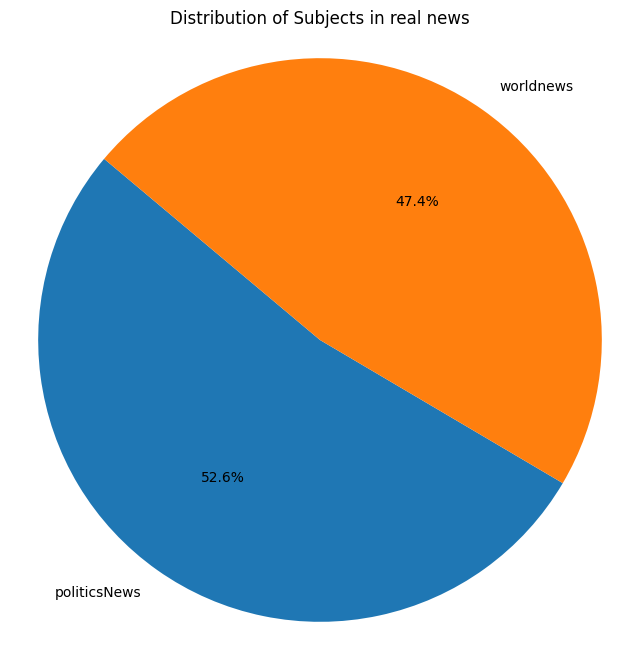

In [ ]:
#Pie chart to visualize the distribution of the news
subject_counts = real_news['subject'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Subjects in real news')
plt.axis('equal')  # Equal aspect ratio makes the pie a circle
plt.show()

<Axes: xlabel='count', ylabel='word'>

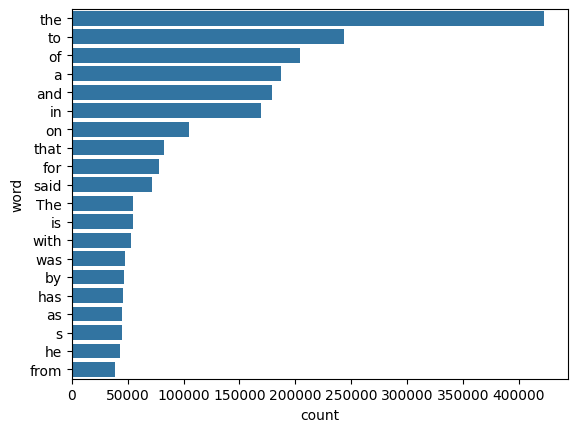

In [ ]:
words = ' '.join(real_news['text']).split()
common_words = Counter(words).most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(data=words_df, y='word', x='count')

In [ ]:
real_news.sample(5)

,title,text,subject,date
8835,Trump stars and spars with Republican lawmakers,WASHINGTON (Reuters) - Donald Trump endured so...,politicsNews,"July 7, 2016"
11406,Vietnam braces for typhoon as Philippine toll ...,HANOI/MANILA (Reuters) - Authorities in Vietna...,worldnews,"December 25, 2017"
2080,Trump to visit Arizona town on U.S.-Mexican bo...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"August 21, 2017"
15297,UAE asks banks for information on 19 Saudis' a...,ABU DHABI/DUBAI (Reuters) - The United Arab Em...,worldnews,"November 9, 2017"
19942,Tanzania charges officials with economic sabot...,DAR ES SALAAM (Reuters) - Tanzanian prosecutor...,worldnews,"September 15, 2017"


In [ ]:
# create list of indexes which do not have publication information by breaking text with hyphen
import re

pattern = re.compile(r'^.{0,119} - .+')

unknown_publishers = [
    i for i, text in enumerate(real_news.text.values)
    if not pattern.match(text)
]

In [ ]:
len(unknown_publishers)

229

In [ ]:
real_news.iloc[unknown_publishers].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [ ]:
find_empty_rows(real_news,'text')

Empty text rows found at indices: [8970]


,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [ ]:
real_news =remove_empty_rows(real_news)

Dropping the following empty row indices: [8970]


In [ ]:
publisher = []
tmp_text = [] # for unknown publishers

for index, row in enumerate(real_news.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real_news['publisher'] = publisher
real_news['text'] = tmp_text


In [ ]:
real_news.shape

(21416, 5)

In [ ]:
publisher

['WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'SEATTLE/WASHINGTON (Reuters)',
 'WEST PALM BEACH, Fla./WASHINGTON (Reuters)',
 'WEST PALM BEACH, Fla (Reuters)',
 'Unknown',
 'Unknown',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'NEW YORK/WASHINGTON (Reuters)',
 'Unknown',
 'Unknown',
 'Unknown',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 '(Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'NEW YORK (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'LIMA (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 'MEXICO CITY (Reuters)',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'VATICAN CITY (Reuters)',
 'KING OF PRUSSIA, Pennsylvania/WASHINGTON (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'NEW YORK (Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 'WASHINGTON (Reuters)',
 'NEW YORK (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)

In [ ]:
real_news['text'] = real_news['title'] + " " + real_news['text']
fake_news['text'] = fake_news['title'] + " " + fake_news['text']

In [ ]:
real_news['text']  = real_news['text'].apply(lambda x: str(x).lower())
fake_news['text'] = fake_news['text'].apply(lambda x: str(x).lower())

In [ ]:
real_news['class'] = 1
fake_news['class'] = 0

In [ ]:
real_news = real_news[['text','class']]

In [ ]:
fake_news = fake_news[['text', 'class']]

In [ ]:
data = pd.concat([real_news, fake_news], ignore_index=True)

In [ ]:
data.sample(20)

,text,class
2175,"factbox: trump's manufacturing panel ceos, com...",1
2912,trump administration defends interpretation of...,1
18547,merkel's conservatives tied with spd ahead of ...,1
4464,senate republican leader starts clock ticking ...,1
1285,trump met stanford's john taylor in fed chair ...,1
44413,request to halt construction of dapl declined ...,0
33448,clinton’s beg for cash as foundation’s ability...,0
7971,"u.s. 9/11 law exasperates saudis, government s...",1
36377,it’s bad enough canadian magazine puts a smili...,0
27034,acclaimed documentarian blasts christians for...,0


PREPROCESSING THE DATA

In [ ]:
import re
import unicodedata
import pandas as pd

In [ ]:
def clean_text(text):

    text = text.lower() # convert all text to lowercase
    text = text.replace('\\', '') # remove all backslashes
    text = text.replace('-', ' ') # remove any additional hyphens
    text = re.sub(r'\S+@\S+', '', text) #remove emails
    text = re.sub(r'@\w+', '', text)  #remove twitter handle
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #remove urls
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  # Remove accented characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters and punctuation (keep only letters and numbers)
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces

    return text

In [ ]:
data['text'] = data['text'].apply(clean_text)

In [ ]:
data['text'].head()

,text
0,as us budget fight looms republicans flip thei...
1,us military to accept transgender recruits on ...
2,senior us republican senator let mr mueller do...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge much more...


using a vectorization technique such as Word2Vec to vectorize the data

In [ ]:
y = data['class'].values


In [ ]:
X=[d.split() for d in data['text'].tolist()]

In [ ]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.key_to_index)

197506

In [ ]:
w2v_model.wv.most_similar('weather')

[('tropical', 0.7090049386024475),
 ('temperatures', 0.6580345630645752),
 ('storms', 0.6523522138595581),
 ('rains', 0.6515286564826965),
 ('irma', 0.6400080323219299),
 ('storm', 0.639491081237793),
 ('floods', 0.6376432180404663),
 ('flooding', 0.6265140771865845),
 ('landslides', 0.6157400608062744),
 ('winds', 0.611072838306427)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
nos = np.fromiter((len(seq) for seq in X), dtype=int)
count = np.sum(nos > 1000)
print(count)

1641


In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def create_embedding_matrix(w2v_model, tokenizer, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_vectors = create_embedding_matrix(w2v_model, tokenizer, 100, vocab_size)

In [ ]:
embedding_vectors.shape

(197507, 100)

MODEL


In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=DIM,
                    weights=[embedding_vectors],
                    trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    19,750,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,750,700 (75.34 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,750,700 (75.34 MB)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=5,
                    batch_size=32,
                    verbose=1)


Epoch 1/5
737/737 ━━━━━━━━━━━━━━━━━━━━ 2147s 3s/step - acc: 0.9041 - loss: 0.2349 - val_acc: 0.9715 - val_loss: 0.0916
Epoch 2/5
737/737 ━━━━━━━━━━━━━━━━━━━━ 2240s 3s/step - acc: 0.9693 - loss: 0.0935 - val_acc: 0.9849 - val_loss: 0.0508
Epoch 3/5
737/737 ━━━━━━━━━━━━━━━━━━━━ 2137s 3s/step - acc: 0.9822 - loss: 0.0523 - val_acc: 0.9866 - val_loss: 0.0451
Epoch 4/5
314/737 ━━━━━━━━━━━━━━━━━━━━ 18:34 3s/step - acc: 0.9858 - loss: 0.0449

In [ ]:
model.save('lstm_with_dropout.h5')

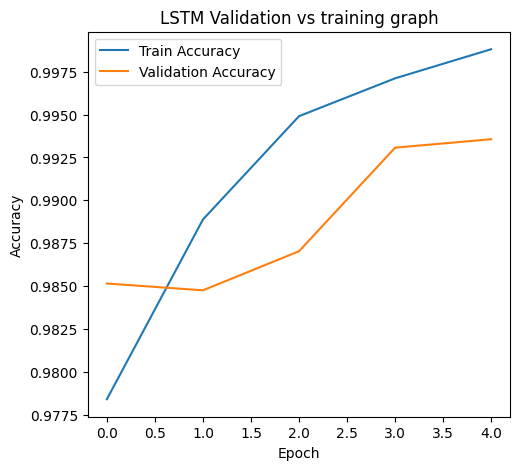

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title( 'LSTM Validation vs training graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

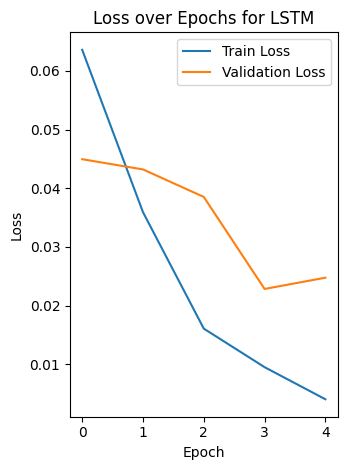

In [ ]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

#Predict probabilities on test data
y_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_probs > 0.5).astype(int)


print(classification_report(y_test, y_pred))

# calculate precision, f1 and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5890
           1       1.00      0.99      0.99      5335

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

Precision: 0.9962
Recall: 0.9897
F1-score: 0.9929


351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


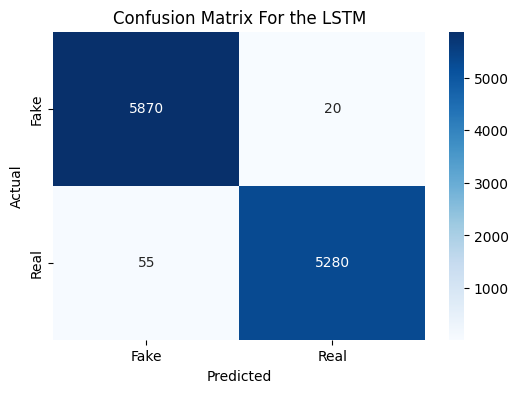

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#Predict and convert to binary
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For the LSTM')
plt.show()


In [ ]:
# check with real news from internet (verified)
sample = ["Trump teases possible US strike as Iran supreme leader warns America"]
seq = tokenizer.texts_to_sequences(sample)
padded = pad_sequences(seq, maxlen=100)
print(model.predict(padded))
label = "Real News" if model.predict(padded)[0][0] > 0.5 else "Fake News"
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[0.01164528]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fake News


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - acc: 0.9936 - loss: 0.0257
Test Accuracy: 0.9933
Test Loss: 0.0246


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)